In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import text, sequence


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# load text processed data
train = pd.read_csv('spellcheck.csv')
train = train.replace(np.nan, '', regex=True)
train['comment_text'][150]

'socialist two important feature smith concept invisible hand first smith advocate social policy people act self interest rather describe observe economic reality people act interest second smith claim self interest beneficial effect community argue self interest always good merely argue view self interest necessarily bad worth note upon death smith leave much personal wealth charity good let make sure put forth idea adam smith socialist wikipedia ways'

In [3]:
df_test = pd.read_csv("spellchecktest.csv")
df_test = df_test.replace(np.nan, '', regex=True)

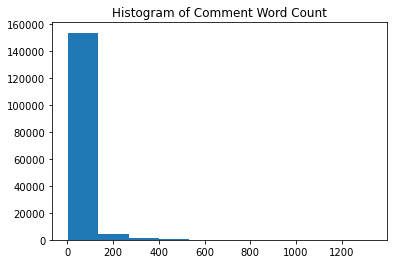

In [4]:
comment_word_count = train['comment_text'].apply(lambda x: len(str(x).split(" ")))
plt.hist(comment_word_count)
plt.title("Histogram of Comment Word Count")
plt.show()

In [5]:
MAX_NB_WORDS = 35000 # number of most frequent words to keep
MAX_SEQUENCE_LENGTH = 200 # number of words to keep per comment

tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train['comment_text'].values)

In [6]:
word_index = tokenizer.word_index
len(word_index) # number of unique tokens

55268

In [7]:
count_list = list(tokenizer.word_counts.items())
len([i for i in range(0,len(count_list)) if count_list[i][1]<3]) # total number of words that appear less than three times

20594

In [8]:
list(word_index.items())[35000][0]

'varus'

In [9]:
train = train.sample(frac=1,random_state=13)
val = train.tail(int(len(train)*(1/10)))
train = train.head(int(len(train)*(9/10)))

In [10]:
# oversample attempt
train_idhate = train[train['identity_hate'] == 1].sample(n=500,random_state=13)
train_threat = train[train['threat'] == 1].sample(n=300,random_state=13)
train = pd.concat([train, train_idhate])
train = pd.concat([train, train_threat])

In [11]:
train = train.sample(frac=1,random_state=133)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,144413.000000,144413.000000,144413.000000,144413.000000,144413.000000,144413.000000
mean,0.100143,0.011280,0.056401,0.005131,0.053299,0.012741
std,0.300192,0.105608,0.230695,0.071448,0.224629,0.112156
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].to_numpy()
X_train = tokenizer.texts_to_sequences(train["comment_text"].values)
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

y_val = val[list_classes].to_numpy()
X_val = tokenizer.texts_to_sequences(val["comment_text"].values)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

In [13]:
print(X_train.shape,y_train.shape)

(144413, 200) (144413, 6)


In [14]:
embeddings_index = {}
f = open('glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
EMBED_SIZE = 300
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBED_SIZE))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [30]:
embedding_layer = layers.Embedding(MAX_NB_WORDS,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

In [31]:
model = keras.Sequential()
model.add(embedding_layer)
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(75, return_sequences=True)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy','AUC'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          10500000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 150)          225600    
_________________________________________________________________
global_max_pooling1d (Global (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 906       
Total params: 10,726,506
Trainable params: 10,726,506
Non-trainable params: 0
_________________________________________________________________


In [33]:
epochs = 2
batch_size = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_val, y_val),callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=0.0001)])

Epoch 1/2
2889/2889 [==============================] - 1053s 364ms/step - loss: 0.0823 - binary_accuracy: 0.9739 - auc: 0.9473 - val_loss: 0.0449 - val_binary_accuracy: 0.9829 - val_auc: 0.9846
Epoch 2/2
2889/2889 [==============================] - 1050s 363ms/step - loss: 0.0408 - binary_accuracy: 0.9840 - auc: 0.9900 - val_loss: 0.0445 - val_binary_accuracy: 0.9832 - val_auc: 0.9851


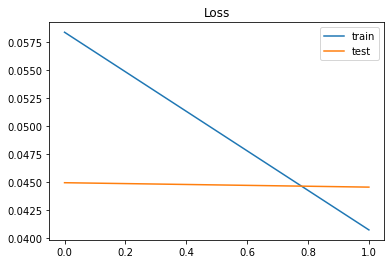

In [34]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

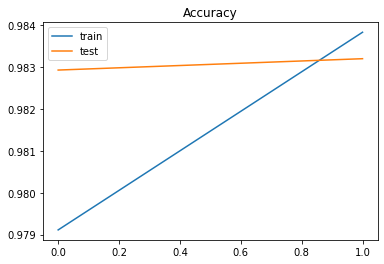

In [35]:
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.legend()
plt.show();

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, model.predict(X_val))

0.9846171265033871